## **Ethiopia Nutrition and Demand System**

In [5]:
%pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [6]:
import pandas as pd
import cfe.regression as rgsn

### From Sheet to DataFrame to Regression Object

In [7]:
Ethiopia_Data = '148rioTUyUTcgjbZCqobeXiufm0gG4evxeWXD-Hr_OiA'

In [8]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt

# Change 'Ethiopia_Data' to key of your own sheet in Sheets, above
x = read_sheets(Ethiopia_Data,sheet='Food Expenditures (2018-19)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia_Data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Get intersection of goods we have prices *and* expenditures for:
jidx = p.columns.intersection(x.index.levels[-1])

# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Household characteristics
d = read_sheets(Ethiopia_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

This gives a dataframe of household characteristics $d$ with a simple structure.

In [9]:
d.head()

k                             Females 00-03  Females 04-08  Females 09-13  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              1              1              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              1              1   
              2013-14 Tigray              1              1              1   

k                             Females 14-18  Females 19-30  Females 31-50  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              0              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              1              0   

k                             Females 51-99  Males 00-03  Males 04-08  \
i             t       m                                                 
1010101601002 2011-12 Tigray              1            0            1   
              2013-14 Tigray              1            0            1   
              2015-16 Tigray              1            0            0   
1010101601017 2011-12 Tigray              0            0            0   
              2013-14 Tigray              0            0            1   

k                             Males 09-13  Males 14-18  Males 19-30  \
i             t       m                                               
1010101601002 2011-12 Tigray            1            1            0   
              2013-14 Tigray            0            1            0   
              2015-16 Tigray            0            0            0   
1010101601017 2011-12 Tigray            2            0            0   
              2013-14 Tigray            1            1            0   

k                             Males 31-50  Males 51-99  log HSize  
i             t       m                                            
1010101601002 2011-12 Tigray            1            0   1.945910  
              2013-14 Tigray            1            0   2.079442  
              2015-16 Tigray            0            0   0.000000  
1010101601017 2011-12 Tigray            1            0   1.791759  
              2013-14 Tigray            1            0   2.079442

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.

In [10]:
y.head()

i                   t        m       j     
010101088800910007  2018-19  Tigray  Coffee    3.401197
                                     Onion     2.197225
                                     Salt      1.098612
                                     Shiro     2.484907
                                     Sugar     2.484907
Name: Expenditure, dtype: float64

Construct a regression object:

In [11]:
r = rgsn.Regression(y=y,d=d)
r.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.722784
                                     Barley       25.973461
                                     Beef        163.760280
                                     Beetroot     10.094725
                                     Berbere      18.426590
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.228985
                                     Tea           6.651267
                                     Teff         66.335750
                                     Tomato        7.975301
                                     Wheat        22.549419
Length: 191958, dtype: float64

## **Demand System**

Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:

In [12]:
fct = read_sheets(Ethiopia_Data,sheet='FCT')

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:

In [13]:
rdi = read_sheets(Ethiopia_Data,sheet='RDI')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#### Reference Prices

Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.


In [14]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

#### Budgets

Get food budget for all households, then find median budget:

In [15]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities

Get quantities of food by dividing expenditures by prices:

In [16]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Banana,Barley,Beef,Beetroot,Berbere,Bread/biscuit,Butter/ghee,Carrot,Chick Pea,Coffee,...,Rice,Salt,Shiro,Soda,Sorghum,Sugar,Tea,Teff,Tomato,Wheat
i,t,m,,,,,,,,,,,,,,,,,,,,,
010101088800910017,2018-19,Tigray,0.413448,0.873332,0.629931,0.394955,0.186324,0.362870,0.101935,0.332159,0.677600,0.161405,...,0.656097,0.114999,0.410137,0.403431,3.539112,0.321945,0.150474,4.458301,0.502392,2.924948
010101088800910026,2018-19,Tigray,0.513472,0.799811,0.617154,0.370081,0.162010,0.309491,0.101811,0.256859,0.563979,0.153774,...,0.557511,0.100283,0.403814,0.419849,3.966817,0.290751,0.149741,4.397499,0.451142,2.399674
010101088800910029,2018-19,Tigray,0.545041,0.715252,0.682824,0.387508,0.227877,0.370559,0.175109,0.285523,0.576399,0.188726,...,0.531924,0.098739,0.438953,0.497123,3.787831,0.310494,0.195002,3.436222,0.570477,2.085938
010101088800910046,2018-19,Tigray,0.420057,0.566860,0.496171,0.376181,0.182603,0.358792,0.123134,0.253919,0.600295,0.167946,...,0.681969,0.109439,0.377164,0.386025,2.931917,0.381308,0.173901,4.099479,0.487625,3.417713
010101088800910054,2018-19,Tigray,0.539680,0.799779,0.648509,0.394967,0.223485,0.399198,0.193097,0.283582,0.676502,0.193055,...,0.713396,0.112441,0.443617,0.477688,4.135037,0.388627,0.218546,4.067916,0.617499,2.716165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.0511E+16,2018-19,Somali,2.205409,3.409047,1.082480,0.837192,0.227766,1.718588,0.232490,1.252165,0.916014,0.345938,...,4.307922,0.315860,1.046515,1.739275,3.821920,2.422879,0.525154,4.201316,1.876677,3.838458
6.0104E+16,2018-19,Benishangul-Gumuz,0.606798,0.768066,0.820877,0.620629,0.348293,0.786185,0.332224,0.720905,0.858413,0.333594,...,0.976222,0.219212,0.652867,0.805118,4.570689,0.759980,0.281383,5.611119,1.139309,2.070048
7.0211E+16,2018-19,SNNP,0.444011,0.828702,0.690302,0.434735,0.267096,0.634788,0.393360,0.537671,0.472582,0.235554,...,0.501562,0.169056,0.464483,0.881795,1.019647,0.373515,0.264338,2.737195,0.813911,1.625396


Define a function to change a single price in the vector $p$:

In [17]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

# **[A] Estimate Demands System**

In [18]:
def plot_demand_by_expenditure(good):
    """
    Plots demand curves for a given good at different household expenditure levels
    (25th, 50th, and 75th percentile) as price changes.

    Parameters:
    good (str): The name of the good for which to plot demand.
    """
    scale = np.linspace(0.5, 2, 20)

    # Demand for household at median budget
    plt.plot(
        [r.demands(xref, my_prices(good, pbar[good] * s, pbar))[good] for s in scale],
        scale,
        label='Median Budget'
    )

    # Demand for household at 25th percentile
    plt.plot(
        [r.demands(xbar.quantile(0.25), my_prices(good, pbar[good] * s, pbar))[good] for s in scale],
        scale,
        label='25th Percentile Budget'
    )

    # Demand for household at 75th percentile
    plt.plot(
        [r.demands(xbar.quantile(0.75), my_prices(good, pbar[good] * s, pbar))[good] for s in scale],
        scale,
        label='75th Percentile Budget'
    )

    plt.ylabel(f"Price (relative to base of {pbar[good]:.2f})")
    plt.xlabel(f"Quantities of {good} Demanded")
    plt.title(f"Demand for {good} at Varying Price Levels")
    plt.legend()
    plt.show()

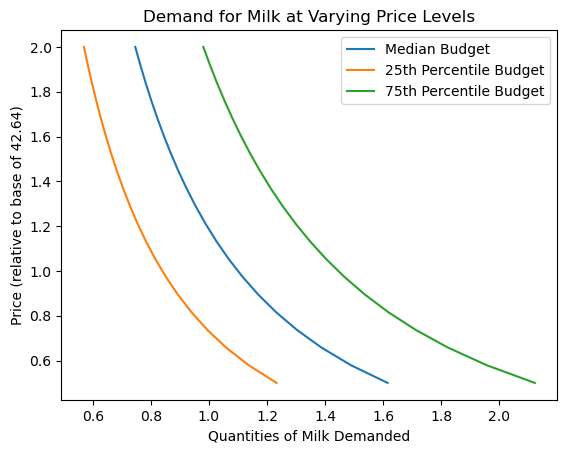

In [19]:
plot_demand_by_expenditure('Milk')

#### Engel Curves

Text(0.5, 1.0, 'Engel Curves')

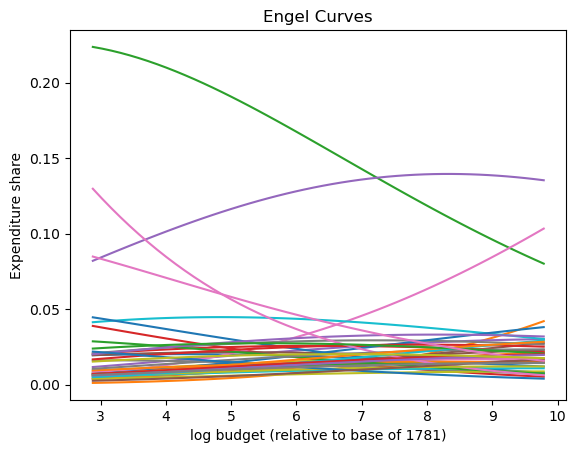

In [20]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients

We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:

In [21]:
fct.head()

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,...,Zinc,Fiber,Folate,Carbohydrate,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin K
j,,,,,,,,,,,,,,,,,,,,,
Avocado,1601.338432,20.0,70,0,20.7,100,2.57,0,120.0,290.0,...,6.4,67.0,810.0,85.3,17.38,520.0,4850.0,1.3,0.67,210.0
Banana,890.000000,11.0,30,0,1.0,87,4.00,0,50.0,270.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barley,3490.000000,123.0,0,0,10.0,0,2.00,0,260.0,920.0,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef,3230.000000,249.0,0,0,0.0,0,3.00,19,40.0,230.0,...,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beer,410.000000,3.0,0,0,0.0,0,1.00,0,50.0,60.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:

In [22]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Banana', 'Barley', 'Beef', 'Beetroot', 'Berbere', 'Bread/biscuit',
       'Butter/ghee', 'Coffee', 'Eggs', 'Fenugreek', 'Garlic',
       'Goat & mutton meat', 'Ground nuts', 'Injera', 'Leafy Greens', 'Maize',
       'Mango', 'Milk', 'Oils', 'Onion', 'Orange', 'Pasta/Macaroni', 'Potato',
       'Rice', 'Salt', 'Soda', 'Sorghum', 'Sugar', 'Tea', 'Teff'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:

In [23]:
# The @ operator means matrix multiply
N = fct0.T@c0

N.head()  #NB: Ethiopia quantities are for previous 7 days

i,010101088800910017,010101088800910026,010101088800910029,010101088800910046,010101088800910054,010101088800910062,010101088800910070,010101088800910082,010101088800910093,010102088801010034,...,3.0714E+16,4.1602E+16,4.2828E+16,4.303E+16,5.01031E+16,5.0511E+16,6.0104E+16,7.0211E+16,7.06101E+16,7.10031E+16
t,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,...,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19
m,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,...,Amhara,Oromia,Oromia,Oromia,Somali,Somali,Benishangul-Gumuz,SNNP,SNNP,SNNP
n,,,,,,,,,,,,,,,,,,,,,
Energy,53380.050977,53235.605392,50429.366970,48685.005319,56341.348321,57372.827743,65603.438217,62248.337280,55325.723046,86878.703613,...,97562.203018,82541.667922,79028.751053,61981.250286,151736.401845,126496.715165,77983.912865,45576.231485,27901.506279,25516.807031
Protein,1736.118281,1722.262115,1610.749420,1570.032496,1768.526338,1949.468521,2210.605769,2019.100747,1906.817566,2787.579815,...,3011.872218,2669.108125,2633.488564,2052.574553,4558.406602,3974.407603,2432.796133,1563.125313,1019.467722,895.658028
Vitamin A,15909.412372,16396.838544,16058.049863,14618.484919,16512.142427,17006.033646,21617.603242,18803.141734,16879.185629,26744.917524,...,27993.394248,21824.279763,22518.621806,18004.982934,70760.489323,66080.713643,25202.554574,25230.587212,13654.831369,12749.045316
Vitamin D,91.351447,90.875650,79.005142,82.119426,81.625516,92.803408,108.313681,92.213723,86.346191,138.177989,...,163.531270,106.812630,118.982946,90.318438,483.779721,414.093006,116.979149,117.597956,88.760439,66.720859
Vitamin E,106.156560,103.536199,111.530046,100.126589,116.467392,117.089583,145.220497,128.756248,117.183547,187.690439,...,244.275972,225.883200,202.042821,178.185166,405.523460,393.619226,192.256175,153.941307,73.723176,78.535618


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.

In [24]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:

Text(0, 0.5, 'log nutrient')

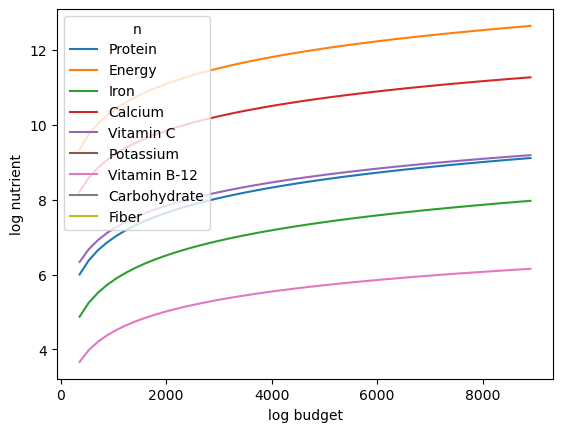

In [25]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C', 'Potassium', 'Vitamin B-12', 'Carbohydrate', 'Fiber']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?

In [26]:
def plot_log_nutrient_vs_price(good):
    """
    Plots log nutrient demand versus price (log-log plot) for all nutrients in UseNutrients for a given good.

    Parameters:
    good (str): The good for which prices are varied.
    """
    scale = np.geomspace(.01, 10, 50)

    ndf = pd.DataFrame({
        s: np.log(nutrient_demand(xref / 2, my_prices(good, pbar[good] * s)))[UseNutrients] for s in scale
    }).T

    ax = ndf.plot()
    ax.set_xlabel('log price')
    ax.set_ylabel('log nutrient')
    ax.set_title(f'Log Nutrient Demand vs. Price for {good}')

    plt.show()


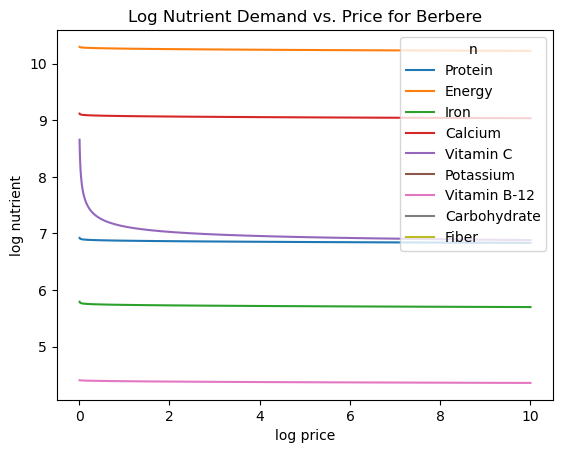

In [27]:
plot_log_nutrient_vs_price('Berbere')

### Nutritional Needs of Households

Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:

In [28]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:

In [29]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           7629.418935
Protein           171.352093
Fiber             106.811865
Folate           1427.377082
Calcium          4482.446160
Carbohydrate      554.995937
Iron               47.710687
Magnesium        1227.683868
Niacin             54.196668
Phosphorus       3346.921983
Potassium       18678.545307
Riboflavin          4.257883
Thiamin             4.131288
Vitamin A        2836.428281
Vitamin B-12        8.564262
Vitamin B-6         4.700223
Vitamin C         261.073751
Vitamin E          53.273872
Vitamin K         343.995327
Zinc               34.263714
dtype: float64

## Nutritional Adequacy of Food Demands

Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.

In [30]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.

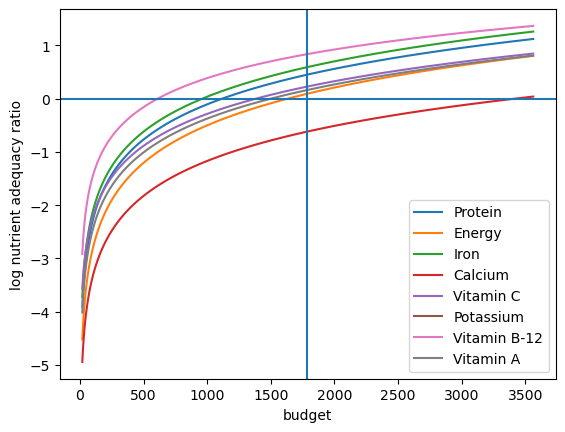

In [31]:
X = np.geomspace(.01*xref,2*xref,100)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C', 'Potassium', 'Vitamin B-12', 'Vitamin A']

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:

In [32]:
def plot_nutrient_price_curve(good, nutrient):
    """
    Plots the relationship between price and log nutrient adequacy ratio for a given nutrient and good.

    Parameters:
    good (str): The good for which prices are varied.
    nutrient (str): The specific nutrient to plot.
    """
    scale = np.geomspace(.01, 2, 50)

    prices = []
    log_ratios = []

    for s in scale:
        price = s * pbar[good]
        try:
            nar = nutrient_adequacy_ratio(xref / 4, my_prices(good, price), dbar)
            log_ratio = np.log(nar[nutrient])
            prices.append(price)
            log_ratios.append(log_ratio)
        except Exception as e:
            # skip or log if needed
            continue

    ndf = pd.DataFrame({
        'Price': prices,
        'log_nutrient_adequacy_ratio': log_ratios
    })

    fig, ax = plt.subplots()
    ax.plot(ndf['log_nutrient_adequacy_ratio'], ndf['Price'])
    ax.axhline(pbar[good], color='grey', linestyle='--', linewidth=1)
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)

    ax.set_ylabel('Price')
    ax.set_xlabel('log nutrient adequacy ratio')
    ax.set_title(f'Nutrient Adequacy of {nutrient} vs. Price for {good}')

    plt.show()

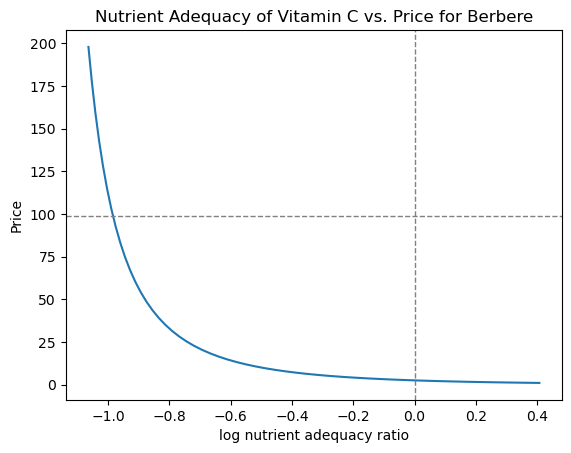

In [33]:
plot_nutrient_price_curve('Berbere', 'Vitamin C')

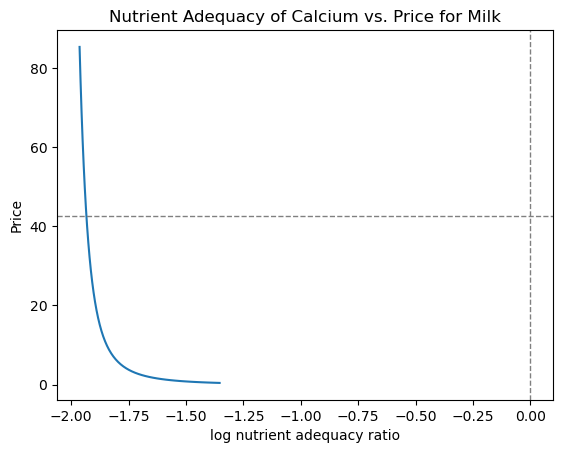

In [34]:
plot_nutrient_price_curve('Milk', 'Calcium')

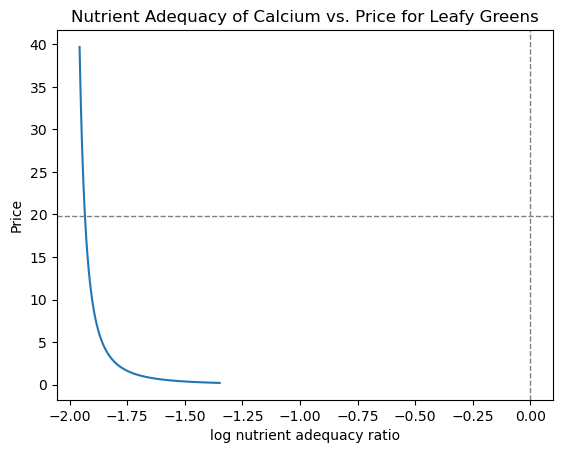

In [35]:
plot_nutrient_price_curve('Leafy Greens', 'Calcium')

# **Cost & Hicksian Curves**

In [36]:
r.consumerdemands

<module 'consumerdemands' from '/srv/conda/lib/python3.11/site-packages/consumerdemands/__init__.py'>

#### Budgets

Get food budget for all households, then find median budget:


In [37]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.20)  # Household at 0.5 quantile is median

#### Marshallian vs. Hicksian Demand Curves

Let&rsquo;s look at Marshallian & Hicksian demands&#x2014;one way of thinking
about the Hicksian (compensated) curves is that they  eliminate the
income effect associated with changing prices.

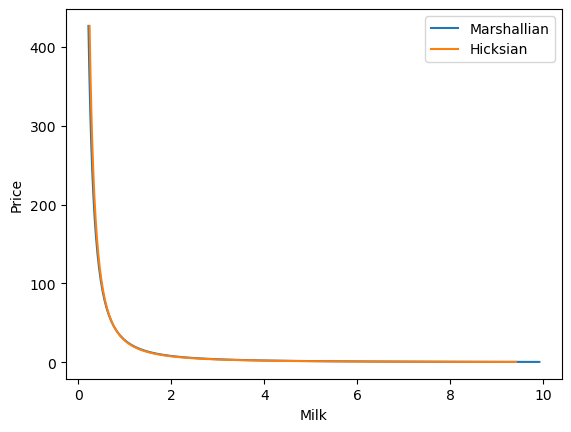

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Milk'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(x0,pbar)

plt.plot([r.demands(x0,my_prices(my_j,p0))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(my_j,p0),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures

In [40]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation

Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.

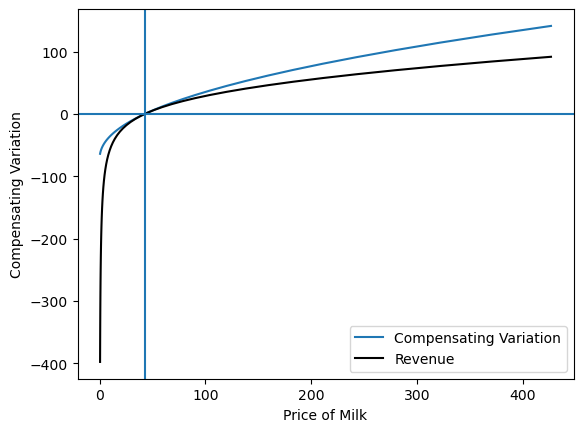

In [41]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(my_j,p0),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss

Differences between revenue and compensating variation is deadweight-loss:

Text(0, 0.5, 'Deadweight Loss')

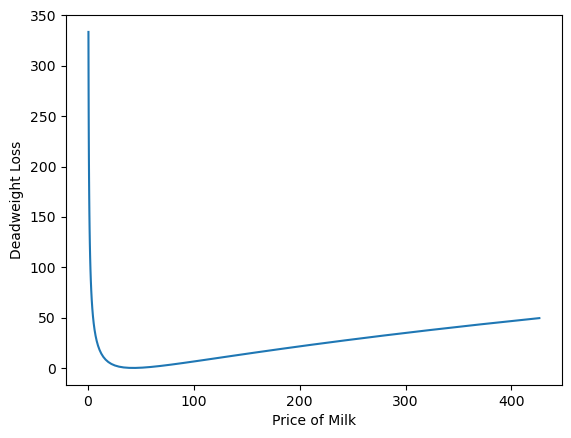

In [42]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")

<Axes: ylabel='Density'>

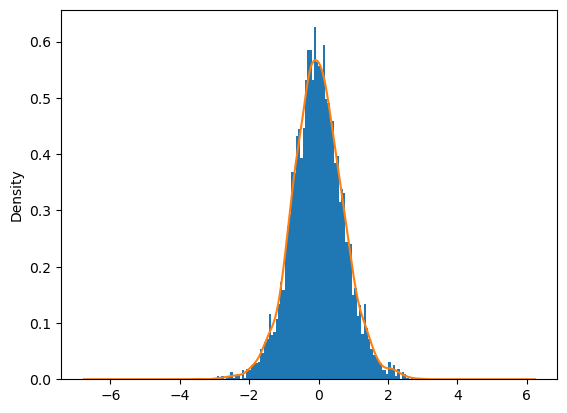

In [43]:
ax = r.get_w().plot.hist(bins=100,density=True)
r.get_w().plot.kde(ax=ax)

# **[A] Policy 1: Cash Transfer and Nutritional Systems**
Contains the adjusted expenditure after a given conditional cash transfer is applied

## Adjusted Expenditure Relative to Conditional Cash Transfer

In [179]:
# === 1. Load Data ===
expenditures = pd.read_csv("Ethiopia_2 - Food Expenditures (2018-19) (1).csv")
prices = pd.read_csv("Ethiopia_2 - Food Prices (2018-19).csv")

def apply_cct_adjustment(cct_amount):
    """
    Applies a conditional cash transfer (CCT) to the bottom 50% of households
    based on total expenditure, and adjusts expenditure and quantity accordingly.

    Parameters:
    - cct_amount (float): Transfer amount to be applied per bottom-50% household (in birr)

    Returns:
    - data (DataFrame): Updated merged DataFrame with CCT, Adjusted_Expenditure, and Adjusted_Quantity
    """
    expenditures = pd.read_csv("Ethiopia_2 - Food Expenditures (2018-19) (1).csv")
    prices = pd.read_csv("Ethiopia_2 - Food Prices (2018-19).csv")
    
    # === 1. Merge Expenditures with Prices ===
    data = pd.merge(
        expenditures,
        prices[['t', 'm', 'j', 'Price']],
        on=['t', 'm', 'j'],
        how='left'
    )
    data = data.dropna(subset=['Price'])

    # === 2. Calculate Quantity Consumed per Food Item ===
    data['Quantity'] = data['Expenditure'] / data['Price']

    # === 3. Classify Households by Total Expenditure ===
    total_exp_by_household = data.groupby('i')['Expenditure'].sum().reset_index()
    total_exp_by_household = total_exp_by_household.rename(columns={'Expenditure': 'Total_Expenditure'})

    # Get median
    median_exp = total_exp_by_household['Total_Expenditure'].median()

    # Assign Bottom/Top 50%
    total_exp_by_household['Group'] = total_exp_by_household['Total_Expenditure'].apply(
        lambda x: 'Bottom 50%' if x <= median_exp else 'Top 50%'
    )

    # Merge group label into full data
    data = data.merge(total_exp_by_household[['i', 'Group']], on='i', how='left')

    # === 4. Simulate Conditional Cash Transfer (CCT) ===
    bottom_50_households = data[data['Group'] == 'Bottom 50%']['i'].drop_duplicates()
    cct_per_household = pd.DataFrame({'i': bottom_50_households, 'CCT': cct_amount})

    # Merge into data
    data = data.merge(cct_per_household, on='i', how='left')
    data['CCT'] = data['CCT'].fillna(0)

    # === 5. Distribute CCT Across Items ===
    household_total_exp = data.groupby('i')['Expenditure'].transform('sum')
    data['CCT_Adjusted'] = data['CCT'] * (data['Expenditure'] / household_total_exp)

    # Final adjusted values
    data['Adjusted_Expenditure'] = data['Expenditure'] + data['CCT_Adjusted']
    data['Adjusted_Quantity'] = data['Adjusted_Expenditure'] / data['Price']

    return data

In [184]:
data = apply_cct_adjustment(100)

                       i  Total_Expenditure       Group
0     010101088800910007               66.0  Bottom 50%
1     010101088800910017              167.0  Bottom 50%
2     010101088800910026              223.0  Bottom 50%
3     010101088800910029              280.0  Bottom 50%
4     010101088800910038              278.0  Bottom 50%
...                  ...                ...         ...
6661          6.0104E+16              681.0     Top 50%
6662          7.0211E+16              499.0     Top 50%
6663         7.06021E+16              349.0  Bottom 50%
6664         7.06101E+16              117.0  Bottom 50%
6665         7.10031E+16              180.0  Bottom 50%

[6666 rows x 3 columns]


## Regression with Adjusted Values

In [185]:
x = data.pivot_table(index=['i','t','m'], columns='j', values='Adjusted_Expenditure', aggfunc='sum')
x = x.stack()
x = x.replace(0, np.nan)
y = np.log(x)

r2 = rgsn.Regression(y=y, d=d)

In [186]:
r2.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       21.194069
                                     Barley       41.655487
                                     Beef        220.827418
                                     Beetroot     12.779568
                                     Berbere      29.200897
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar        12.525178
                                     Tea           9.530089
                                     Teff         96.255595
                                     Tomato       12.424984
                                     Wheat        32.943774
Length: 191958, dtype: float64

In [187]:
xhat = r2.predicted_expenditures()
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)

## Comparison of Engle Curves Pre and Post CCT

In [188]:
def plot_top_engel_curves(r_model):
    """
    Plots Engel curves for the top 10 most consumed goods using predicted expenditures
    from a fitted regression model.

    Parameters:
    - r_model (Regression): A fitted regression object (e.g., r2)

    Assumes global `pbar` (dict of average prices).
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Step 1: Get predicted expenditures and reshape to wide format
    xhat_long = r_model.predicted_expenditures()
    xhat = xhat_long.unstack('j').fillna(0)

    # Step 2: Compute total expenditure per household and reference budget
    total_exp = xhat.sum(axis=1)
    xref = total_exp.median()

    # Step 3: Identify top 10 goods by total predicted expenditure
    top_goods = xhat.sum().sort_values(ascending=False).head(10).index.tolist()

    # Step 4: Generate Engel curves
    scale = np.geomspace(0.01, 10, 50)
    fig, ax = plt.subplots(figsize=(10, 6))

    for good in top_goods:
        shares = []
        for s in scale:
            exp = r_model.expenditures(s * xref, pbar)
            if good in exp:
                shares.append(exp[good] / (s * xref))
            else:
                shares.append(np.nan)
        ax.plot(np.log(scale * xref), shares, label=good)

    ax.set_xlabel(f'log Budget (relative to base of {xref:.0f})')
    ax.set_ylabel('Expenditure Share')
    ax.set_title('Engel Curves: Top 10 Most Predicted Goods')
    ax.legend(title='Good', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

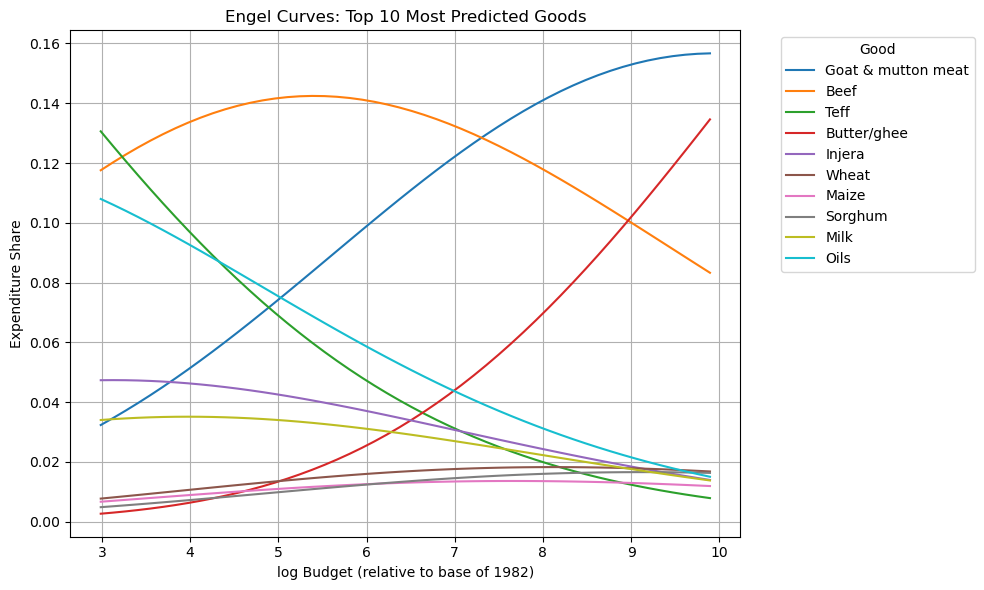

In [189]:
plot_top_engel_curves(r2)

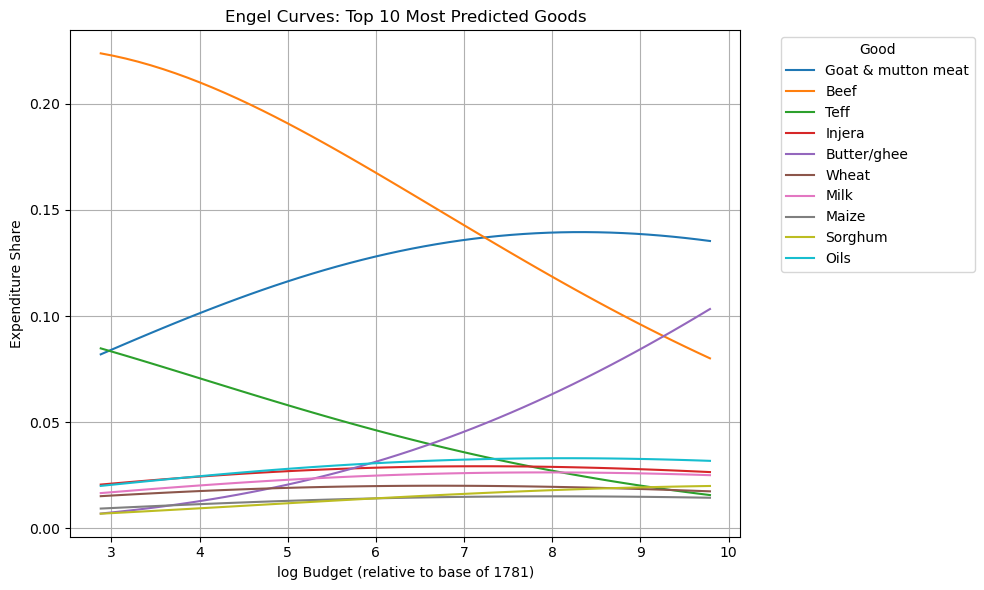

In [190]:
plot_top_engel_curves(r)

## Hicksian Demand Function (in progress)

## Comparing Demand Curves Pre and Post CCT

In [90]:
import numpy as np

def plot_demand_curve_bottom50(food_item, data, price_points=20):
    """
    Plots a demand curve for a specific food item using observed adjusted household expenditures.
    Simulates quantity demanded at different price levels for the 25th and 50th percentile budgets,
    assuming only bottom 50% of households are included in the dataset.

    Parameters:
    - food_item (str): Food name to filter and plot
    - data (DataFrame): Full merged DataFrame with 'j', 'Adjusted_Expenditure', and 'Price'
    - price_points (int): Number of price scale points for the curve
    """
    # Filter for the selected food
    df = data[data['j'] == food_item].copy()
    
    if df.empty:
        print(f"No data found for '{food_item}'")
        return

    # Compute total adjusted budget per household (post-CCT)
    adj_budget = df.groupby('i')['Adjusted_Expenditure'].sum()

    # Get 25th and 50th percentiles only
    q25 = adj_budget.quantile(0.25)
    q50 = adj_budget.quantile(0.50)

    # Use median price of the food as baseline
    base_price = df['Price'].median()
    price_scale = np.linspace(0.5, 2.0, price_points)

    # Simulate demand: Q = Budget / (Price)
    def simulate_demand_curve(budget):
        return [budget / (base_price * p) for p in price_scale]

    q25_curve = simulate_demand_curve(q25)
    q50_curve = simulate_demand_curve(q50)

    # Plot
    plt.plot(q50_curve, price_scale, label='Median Budget (50th Percentile)')
    plt.plot(q25_curve, price_scale, label='25th Percentile Budget')

    plt.xlabel(f'Quantity of {food_item} Demanded')
    plt.ylabel(f'Price (relative to base of {base_price:.2f})')
    plt.title(f'Demand for {food_item} at Varying Price Levels (Bottom 50%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

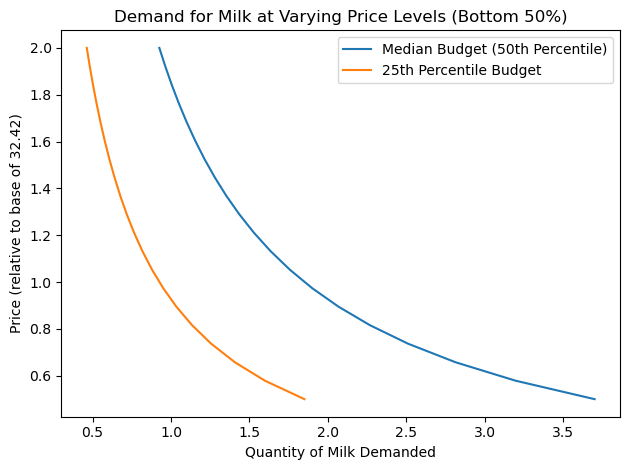

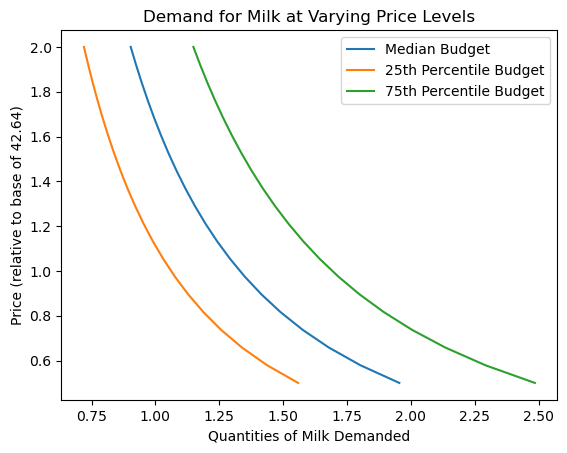

In [91]:
plot_demand_curve_bottom50('Milk', data)
plot_demand_by_expenditure('Milk')

In [70]:
def plot_nutrient_price_curve(food, nutrient, data):
    """
    Plots the relationship between price and log nutrient adequacy ratio (NAR)
    for a given food and nutrient using existing demand system parameters.

    Assumes the following are pre-defined in the notebook:
    - xref: reference household expenditure
    - pbar: dictionary of base prices
    - dbar: demographic vector
    - rdi: DataFrame of nutrient requirements per demographic group
    - my_prices: function to construct a price vector with one good changed
    - nutrient_demand: function to compute nutrient intake given x and p
    """

    xbar = data.groupby('i')['Adjusted_Expenditure'].sum()
    xref = xbar.median()  # or xbar.quantile(0.5)
    
    def nutrient_adequacy_ratio(x, p, d, rdi=rdi, days=7):
        hh_rdi = rdi.replace('', 0) @ d * days  # total household requirement
        return nutrient_demand(x, p) / hh_rdi

    scale = np.geomspace(0.01, 2.0, 50)
    prices = []
    log_ratios = []

    for s in scale:
        price = s * pbar[food]
        try:
            nar = nutrient_adequacy_ratio(xref, my_prices(food, price), dbar)
            if nutrient not in nar or nar[nutrient] <= 0:
                continue
            log_ratio = np.log(nar[nutrient])
            prices.append(price)
            log_ratios.append(log_ratio)
        except Exception:
            continue

    if not prices:
        print(f"No valid values for {food} and {nutrient}.")
        return

    df = pd.DataFrame({
        'Price': prices,
        'log_nutrient_adequacy_ratio': log_ratios
    })

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df['log_nutrient_adequacy_ratio'], df['Price'], label=f'{nutrient} adequacy')
    ax.axhline(pbar[food], linestyle='--', color='gray', label='Base price')
    ax.axvline(0, linestyle='--', color='red', label='Adequacy threshold (log = 0)')

    ax.set_xlabel("log Nutrient Adequacy Ratio")
    ax.set_ylabel("Price")
    ax.set_title(f"{nutrient} Adequacy vs. Price for {food}")
    ax.legend()
    plt.tight_layout()
    plt.show()

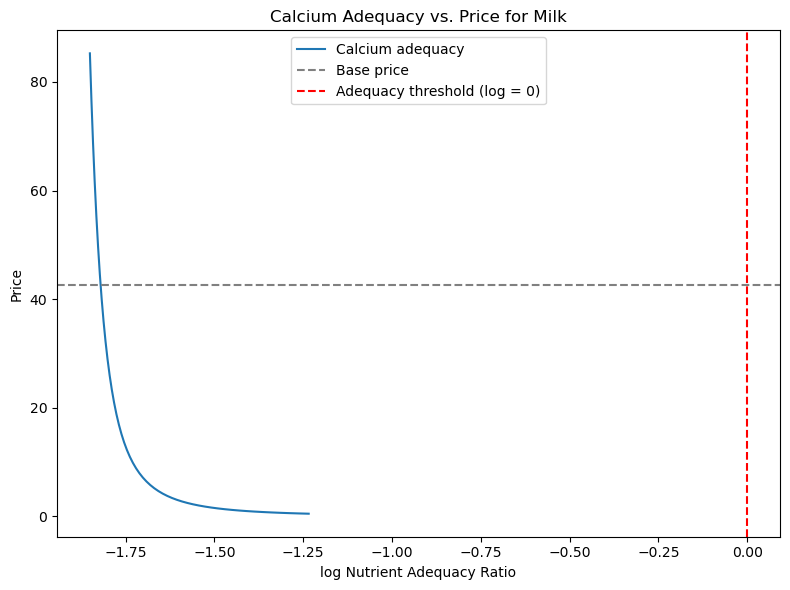

In [71]:
plot_nutrient_price_curve('Milk', 'Calcium', data)

## Comparing Nutritional Adequacy Compared vs. Budget Pre and Post CCT

In [162]:
def plot_nutrient_adequacy_by_adjusted_budget(UseNutrients, days=7):
    """
    Plots log nutrient adequacy ratios for specified nutrients across a range of budgets
    using the same logic and structure as the one-liner version.
    
    Parameters:
    - data (DataFrame): Must include 'Adjusted_Expenditure' for each household
    - UseNutrients (list): List of nutrients to include in the plot
    - days (int): Time horizon for adequacy calculation (default 7)
    """

    # Step 1: Compute household-level adjusted budgets and median
    xhat = r2.predicted_expenditures()
    xbar = xhat.groupby(['i','t','m']).sum()

    # Reference budget
    xref = xbar.quantile(0.5)

    # Step 2: Define budget range (same as one-liner)
    X = np.geomspace(.01*xref,2*xref,100)

    # Step 3: Define nutrient adequacy ratio function (same as one-liner)
    def nutrient_adequacy_ratio(x, p, d, rdi=rdi, days=7):
        hh_rdi = rdi.replace('', 0) @ d * days
        return nutrient_demand(x, p) / hh_rdi

    # Step 4: Build results DataFrame (same as one-liner)
    result_df = pd.DataFrame({
        x: np.log(nutrient_adequacy_ratio(x, pbar, dbar))[UseNutrients]
        for x in X
    }).T
    result_df.index.name = 'Budget'

    # Step 5: Plot
    result_df.plot()
    plt.axhline(0, label='Adequacy Threshold')
    plt.axvline(xref, label='Median Budget (xref)')
    plt.xlabel('Household Budget')
    plt.ylabel('log Nutrient Adequacy Ratio')
    plt.title('Nutrient Adequacy vs. Budget (Post-CCT)')
    plt.legend(UseNutrients)
    plt.tight_layout()
    plt.show()

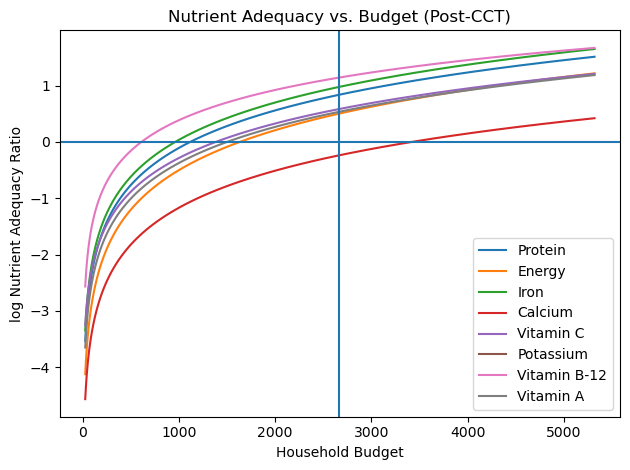

In [163]:
plot_nutrient_adequacy_by_adjusted_budget(UseNutrients, days=7)

In [154]:
def plot_nutrient_adequacy_by_normal_budget(UseNutrients, days=7):
    """
    Plots log nutrient adequacy ratios for specified nutrients across a range of budgets
    using the same logic and structure as the one-liner version.
    
    Parameters:
    - data (DataFrame): Must include 'Adjusted_Expenditure' for each household
    - UseNutrients (list): List of nutrients to include in the plot
    - days (int): Time horizon for adequacy calculation (default 7)
    """

    # Step 1: Compute household-level adjusted budgets and median
    xhat = r.predicted_expenditures()
    xbar = xhat.groupby(['i','t','m']).sum()

    # Reference budget
    xref = xbar.quantile(0.5)

    # Step 2: Define budget range (same as one-liner)
    X = np.geomspace(.01*xref,2*xref,100)

    # Step 3: Define nutrient adequacy ratio function (same as one-liner)
    def nutrient_adequacy_ratio(x, p, d, rdi=rdi, days=7):
        hh_rdi = rdi.replace('', 0) @ d * days
        return nutrient_demand(x, p) / hh_rdi

    # Step 4: Build results DataFrame (same as one-liner)
    result_df = pd.DataFrame({
        x: np.log(nutrient_adequacy_ratio(x, pbar, dbar))[UseNutrients]
        for x in X
    }).T
    result_df.index.name = 'Budget'

    # Step 5: Plot
    result_df.plot()
    plt.axhline(0, label='Adequacy Threshold')
    plt.axvline(xref, label='Median Budget (xref)')
    plt.xlabel('Household Budget')
    plt.ylabel('log Nutrient Adequacy Ratio')
    plt.title('Nutrient Adequacy vs. Budget (Post-CCT)')
    plt.legend(UseNutrients)
    plt.tight_layout()
    plt.show()

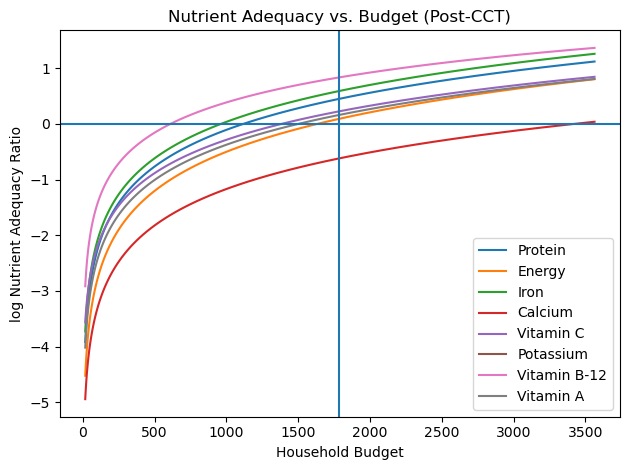

In [155]:
plot_nutrient_adequacy_by_normal_budget(UseNutrients, days=7)